In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

**MLE for time-inhomogenous OU processes**

We consider the time-inhomogeneous OU processes with the following SDE:

$dX_t = (-r(X_t - m(t)) + m'(t))dt + dW_t$

where $m(t) = \alpha ((t+1)^{\beta} - 1) + m_0$

This process possess mean-reverting property with its mean:

$E(X_t) = m(t)$

The code implements MLE for observations from from the time-inhomogenous OU processes. Their maximum likelihood is obtained by their tracatble transition densities

In [2]:
class OU:
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        
        beta_t = self.alpha * ((( self.pts[:-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[1:] + 1)**self.beta) - 1) + m0)

        for t in range(1, len(self.pts)):
            # if the distance is too small, variance becomes 0
            mean = (output[t-1] - beta_t[t-1]) * np.exp(-1 * self.r * interval[t-1] )
            sd = np.sqrt(self.sigma * interval[t-1])
#             print(mean, sd)
            assert sd > 0, "standard deviation is negative, sd:%.3f interval: %.3f" % (sd, interval[t-1] )
            output[t] = ss.norm.rvs(loc = mean, scale = sd)
            
        return torch.from_numpy(output), interval

In [3]:
m0 = 1.7922
alpha = 2.633
beta = 0.5964
sigma = 1
r = 0.0124

In [4]:
true_sde = OU(0, 2, m0, m0, alpha, beta, sigma, r, dN = 30)
true_sde_trj, true_sde_dt = true_sde.simulate()

In [5]:
func = lambda x: alpha * (((x + 1) ** beta) - 1) + m0

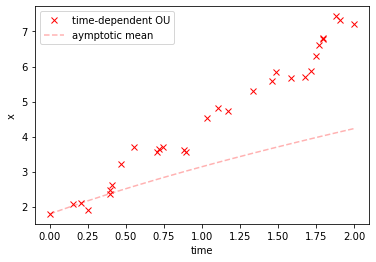

In [24]:
plt.plot(true_sde.pts, true_sde_trj, 'rx', label = 'time-dependent OU')
plt.plot(true_sde.pts, func(true_sde.pts), linestyle='dashed', color='red', alpha=0.3, label='aymptotic mean')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [7]:
class MLE:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        
        sigma = torch.tensor(self.ou.sigma)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
 
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            """
            beta_t = alpha * (((pts[:-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[1:] + 1) ** beta) - 1) + m0) 
            term2 = X[1:] - (X[:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = 2 * (sigma ** 2) * dt
            return -1 * torch.sum(term2 ** 2 / term3)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)

        NLL.backward()
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

In [8]:
beta_ = torch.tensor([0.5], dtype=torch.float64)
alpha_ = torch.tensor([1.], dtype=torch.float64)
r_ =torch.tensor([0.01], dtype=torch.float64)

learning_rate = 0.00001
for i in range(50000):
    mle = MLE(true_sde)
    update = mle.compute_score(beta = beta_, alpha=alpha_, m0=torch.tensor(m0), r=r_)
    beta_ +=  learning_rate * update['beta']
    alpha_ += learning_rate * update['alpha']
    r_ += learning_rate * update['r']
    if i % 10000 == 0:
        print("beta = ", beta_.data.numpy(), 'alpha = ', alpha_.data.numpy(), 'r = ', r_.data.numpy())
        print("MLE = ", update['LNN'])

beta =  [0.50002325] alpha =  [1.00000806] r =  [0.00997775]
MLE =  -11.332194251712798
beta =  [0.71625714] alpha =  [1.07913852] r =  [-0.12743956]
MLE =  -10.592822647172609
beta =  [0.91764529] alpha =  [1.15495674] r =  [-0.14532905]
MLE =  -10.119387646561544
beta =  [1.08650926] alpha =  [1.21340475] r =  [-0.09576841]
MLE =  -9.770149324059307
beta =  [1.17744435] alpha =  [1.23094182] r =  [-0.02901166]
MLE =  -9.63249627669435


In [26]:
print("true alpha = ", alpha, "true beta = ", beta)
print("fitted alpha= ", alpha_.data.numpy()[0], "fitted beta = ", beta_.data.numpy()[0])

true alpha =  2.633 true beta =  0.5964
fitted alpha=  1.217534151819129 fitted beta =  1.2090605631253137


In [10]:
post_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

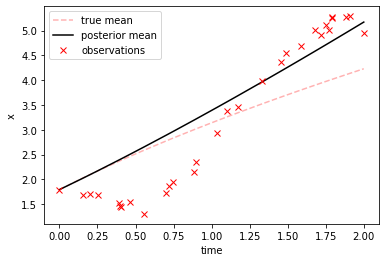

In [21]:
plt.plot(true_sde.pts, func(true_sde.pts), color='r', alpha=0.3, linestyle='dashed', label="true mean")
plt.plot(true_sde.pts, post_mean(true_sde.pts), color='black', label="posterior mean")
plt.plot(true_sde.pts, true_sde.trj, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

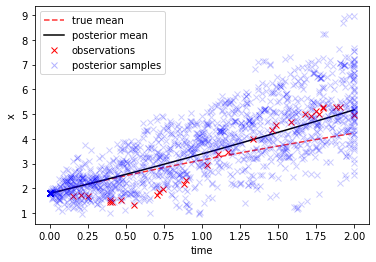

In [18]:
plt.plot(true_sde.pts, func(true_sde.pts), color='r', alpha=0.8, linestyle='dashed', label="true mean")
plt.plot(true_sde.pts, post_mean(true_sde.pts), color='black', label="posterior mean")
plt.plot(true_sde.pts, true_sde.trj, 'rx', label='observations')
for i in range(50):
    vi = OU(0, 2, m0, m0, alpha_, beta_, sigma, r_, dN = 30)
    plt.plot(vi.pts, vi.trj, 'bx', alpha=0.2)
    if i == 49:
        plt.plot(vi.pts, vi.trj, 'bx', alpha=0.3, label='posterior samples')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

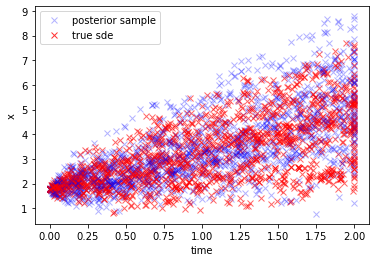

In [20]:
for i in range(50):
    vi = OU(0, 2, m0, m0, alpha_, beta_, sigma, r_, dN = 30)
    pr = OU(0, 2, m0, m0, alpha, beta, sigma, r, dN=30)
    plt.plot(vi.pts, vi.trj, 'bx', alpha=0.3)
    plt.plot(pr.pts, pr.trj, 'rx', alpha=0.6)
    
plt.plot(vi.pts, vi.trj, 'bx', alpha=0.3, label='posterior sample')
plt.plot(pr.pts, pr.trj, 'rx', alpha=0.8, label='true sde')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()